# Fitting Gravitationally Lensed Quasar Light Curves with GausSN

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at

os.chdir('..')
from GausSN import gausSN, kernels, meanfuncs, lensingmodels, utils
os.chdir('./ipynb/')

plt.style.use('./stylesheet/GausSN.mplstyle')

## Define a few functions that will be useful for plotting

In [2]:
def plot_quasar(data, color_dict={'image_1': 'darkblue', 'image_2': 'crimson', 'image_3': 'darkgreen', 'image_4': 'darkorange'},
                marker_dict={'image_1': 'o', 'image_2': 's', 'image_3': '>', 'image_4': '<'}, title='Gravitationally Lensed Quasar'):
    
    # Create subplots based on the number of unique bands
    fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)

    for b, pb_id in enumerate(['EulerCAM', 'WFI']):
        band = data[data['band'] == pb_id]

        # Plot flux for each image in the band
        for im_id in np.unique(data['image']):
            image = band[band['image'] == im_id]

            _, _, bars = ax[b].errorbar(image['time'], image['fluxcal'], yerr=image['fluxcalerr'], ls='None', marker=marker_dict[im_id],
                                        color=color_dict[im_id], label='Image '+im_id[-1])
            [bar.set_alpha(0.5) for bar in bars]
        # Set ylabel for the band
        ax[b].set_ylabel(pb_id, fontsize=14)

    # Add legend and xlabel
    ax[0].legend()
    ax[-1].set_xlabel('Time [days]', fontsize=14)
    ax[0].set_title(title, fontsize=24)
    
    # Set ylabel for the flux and adjust subplot spacing
    fig.supylabel('Flux', fontsize=20, y=0.494)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    return fig, ax

def plot_fitted_quasar(data, results, kernel, meanfunc, lensingmodel, predict_times = np.linspace(-30, 110, 50),
                       color_dict_data = {'image_1': 'darkblue', 'image_2': 'crimson', 'image_3': 'darkgreen', 'image_4': 'tab:orange'},
                       color_dict_fit = {'image_1': 'tab:blue', 'image_2': 'palevioletred', 'image_3': 'tab:green', 'image_4': 'darkorange'},
                       marker_dict={'image_1': 'o', 'image_2': 's', 'image_3': '>', 'image_4': '<'}, title='Fitted Gravitationally Lensed Quasar'):

    # Create subplots based on the number of unique bands
    fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)

    # Plot flux measurements for each band and image
    for b, pb_id in enumerate(['EulerCAM', 'WFI']):
        band = data[data['band'] == pb_id]

        for im_id in np.unique(data['image']):
            image = band[band['image'] == im_id]

            ax[b].errorbar(image['time'], image['fluxcal'], yerr=image['fluxcalerr'], ls='None', marker=marker_dict[im_id],
                        color=color_dict_data[im_id], label='Image '+im_id[-1], zorder=2)
        ax[b].set_ylabel(pb_id, fontsize=16)

    # Get equal-weighted samples from the results
    samples = results.samples_equal()

    # Iterate over random samples from the posterior
    for iter in np.random.choice(len(samples), 200):
        sample = samples[iter]

        kernel_params = [sample[i] for i in range(len(kernel.params))]
        meanfunc_params = [sample[i+len(kernel.params)] for i in range(len(meanfunc.params))]
        lensing_params = [sample[i+len(kernel.params)+len(meanfunc.params)] for i in range(len(lensingmodel.params))]
        kernel._reset(kernel_params)
        meanfunc._reset(meanfunc_params)
        lensingmodel._reset(lensing_params)
        
        # Create GP object
        gp = gausSN.GP(kernel, meanfunc, lensingmodel)
        
        # Predict flux for each band
        for b, pb_id in enumerate(['EulerCAM', 'WFI']):
            band = data[data['band'] == pb_id]

            repeats = np.array([len(band[band['image'] == pb_id]) for pb_id in np.unique(data['image'])])
            delta_vector = np.repeat(gp.lensingmodel.deltas, repeats)
            beta_vector = np.repeat(gp.lensingmodel.betas, repeats)
            shifted_time_data = gp.lensingmodel._time_shift(np.array(band['time'].value), delta_vector)
            b_vector = gp.lensingmodel._magnify(shifted_time_data, beta_vector)

            exp, cov = gp.predict(predict_times, shifted_time_data, band['fluxcal']/b_vector, band['fluxcalerr']/b_vector, band = [pb_id])
            y_vals = np.random.multivariate_normal(mean=exp, cov=cov, size=1)

            for m, im_id in enumerate(np.unique(data['image'])):
                
                repeats = np.zeros(len(np.unique(data['image'])), dtype='int')
                repeats[m] = int(len(predict_times))
                delta_vector_predict = np.repeat(gp.lensingmodel.deltas, repeats)
                beta_vector_predict = np.repeat(gp.lensingmodel.betas, repeats)
                b_vector_predict = gp.lensingmodel._magnify(np.array(predict_times), beta_vector_predict)

                ax[b].plot(predict_times + delta_vector_predict, y_vals[0] * b_vector_predict, color=color_dict_fit[im_id], alpha=0.02, zorder=1)
    
    # Add legend, xlabel, title, and adjust plot limits
    ax[0].legend(loc='upper right')
    ax[-1].set_xlabel('Time [days]', fontsize=16)
    ax[0].set_title(title, fontsize=24)

    # Set ylabel for the flux and adjust subplot spacing
    fig.supylabel('Flux', fontsize=20, y=0.494)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    return fig, ax

## Open the data, process to get in the right format for GausSN, and plot the light curves!

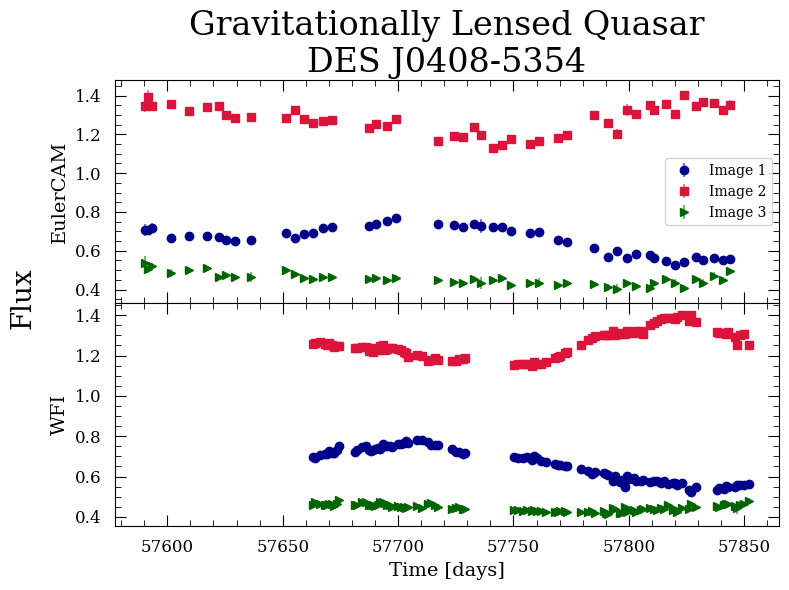

In [3]:
def get_flux(mag, magerr, zp = 27.5):
    flux = 10**((mag - zp) / -2.5)
    fluxerr = flux * magerr * np.log(10)/2.5
    return flux, fluxerr

data_unprocessed = at.Table.read('../data/COSMOGRAIL/DES_J0408-5354.txt', format='ascii')
data = at.Table(names=['time', 'band', 'fluxcal', 'fluxcalerr', 'image'], dtype=['float', 'str', 'float', 'float', 'str'])

for t, tag in enumerate(['A', 'B', 'D']):
    image_col = np.repeat(f'image_{t+1}', len(data_unprocessed))
    band_col = data_unprocessed['telescope']
    flux_col, fluxerr_col = get_flux(data_unprocessed[f'mag_{tag}'], data_unprocessed[f'magerr_{tag}'], zp = 27.5)

    temp = at.Table([data_unprocessed['mhjd'], band_col, flux_col, fluxerr_col, image_col],
                    names=['time', 'band', 'fluxcal', 'fluxcalerr', 'image'], dtype=['float', 'str', 'float', 'float', 'str'])

    data = at.vstack([data, temp])

data.sort(['band', 'image', 'time'])
factor = np.max(data['fluxcal']) - np.min(data['fluxcal'])
data['fluxcal'] = data['fluxcal']/factor
data['fluxcalerr'] = data['fluxcalerr']/factor

fig, ax = plot_quasar(data, title='Gravitationally Lensed Quasar\nDES J0408-5354')

## Fit a GP using Dynesty Nested Sampling for parameter optimization

In [4]:
def ptform(u):
    prior = u
    prior[0] = (u[0] * 5)               # A, amplitude of kernel fluctuations
    prior[1] = (u[1] * 500)             # tau, time-scale of kernel fluctuations
    prior[2] = (u[2] * 1) + 0.2         # c, constant mean function centering
                                        # because quasar flux is never zero, we need to fit for a non-zero constant mean
    prior[3] = (u[3] * 200)             # delta_1,2
    prior[4] = (u[4] * 4.99) + 0.01     # beta_1,2
    prior[5] = (u[5] * 200)             # delta_1,3
    prior[6] = (u[6] * 4.99) + 0.01     # beta_1,3
    return(prior)

A_init, tau_init = 1, 50
c_init = 0.6
delta_init, beta_init = 0, 1

kernel = kernels.OUKernel([A_init, tau_init])
meanfunc = meanfuncs.UniformMean([c_init])
lensingmodel = lensingmodels.ConstantMagnification([delta_init, beta_init, delta_init, beta_init])
gp = gausSN.GP(kernel, meanfunc, lensingmodel)

# To save some time, I only fit the data from one telescope (EulerCAM). Fitting will take ~8 mins in this case (at least on my computer).
# If you don't mind waiting a while to get a better fit from all the data, you can comment out the below!
# (not sure how long it'll take to finish given the above priors)
data = data[data['band'] != 'WFI']

sampler = gp.optimize_parameters(x = data['time'], y = data['fluxcal'], yerr = data['fluxcalerr'], band = data['band'], image = data['image'],
                                 method='dynesty', ptform=ptform, sampler_kwargs = {'sample': 'rslice'})

14778it [07:29, 32.86it/s, +500 | bound: 76 | nc: 1 | ncall: 766983 | eff(%):  1.993 | loglstar:   -inf < 338.749 <    inf | logz: 309.822 +/-  0.244 | dlogz:  0.001 >  0.509]


## Corner & trace plots for dynesty fit

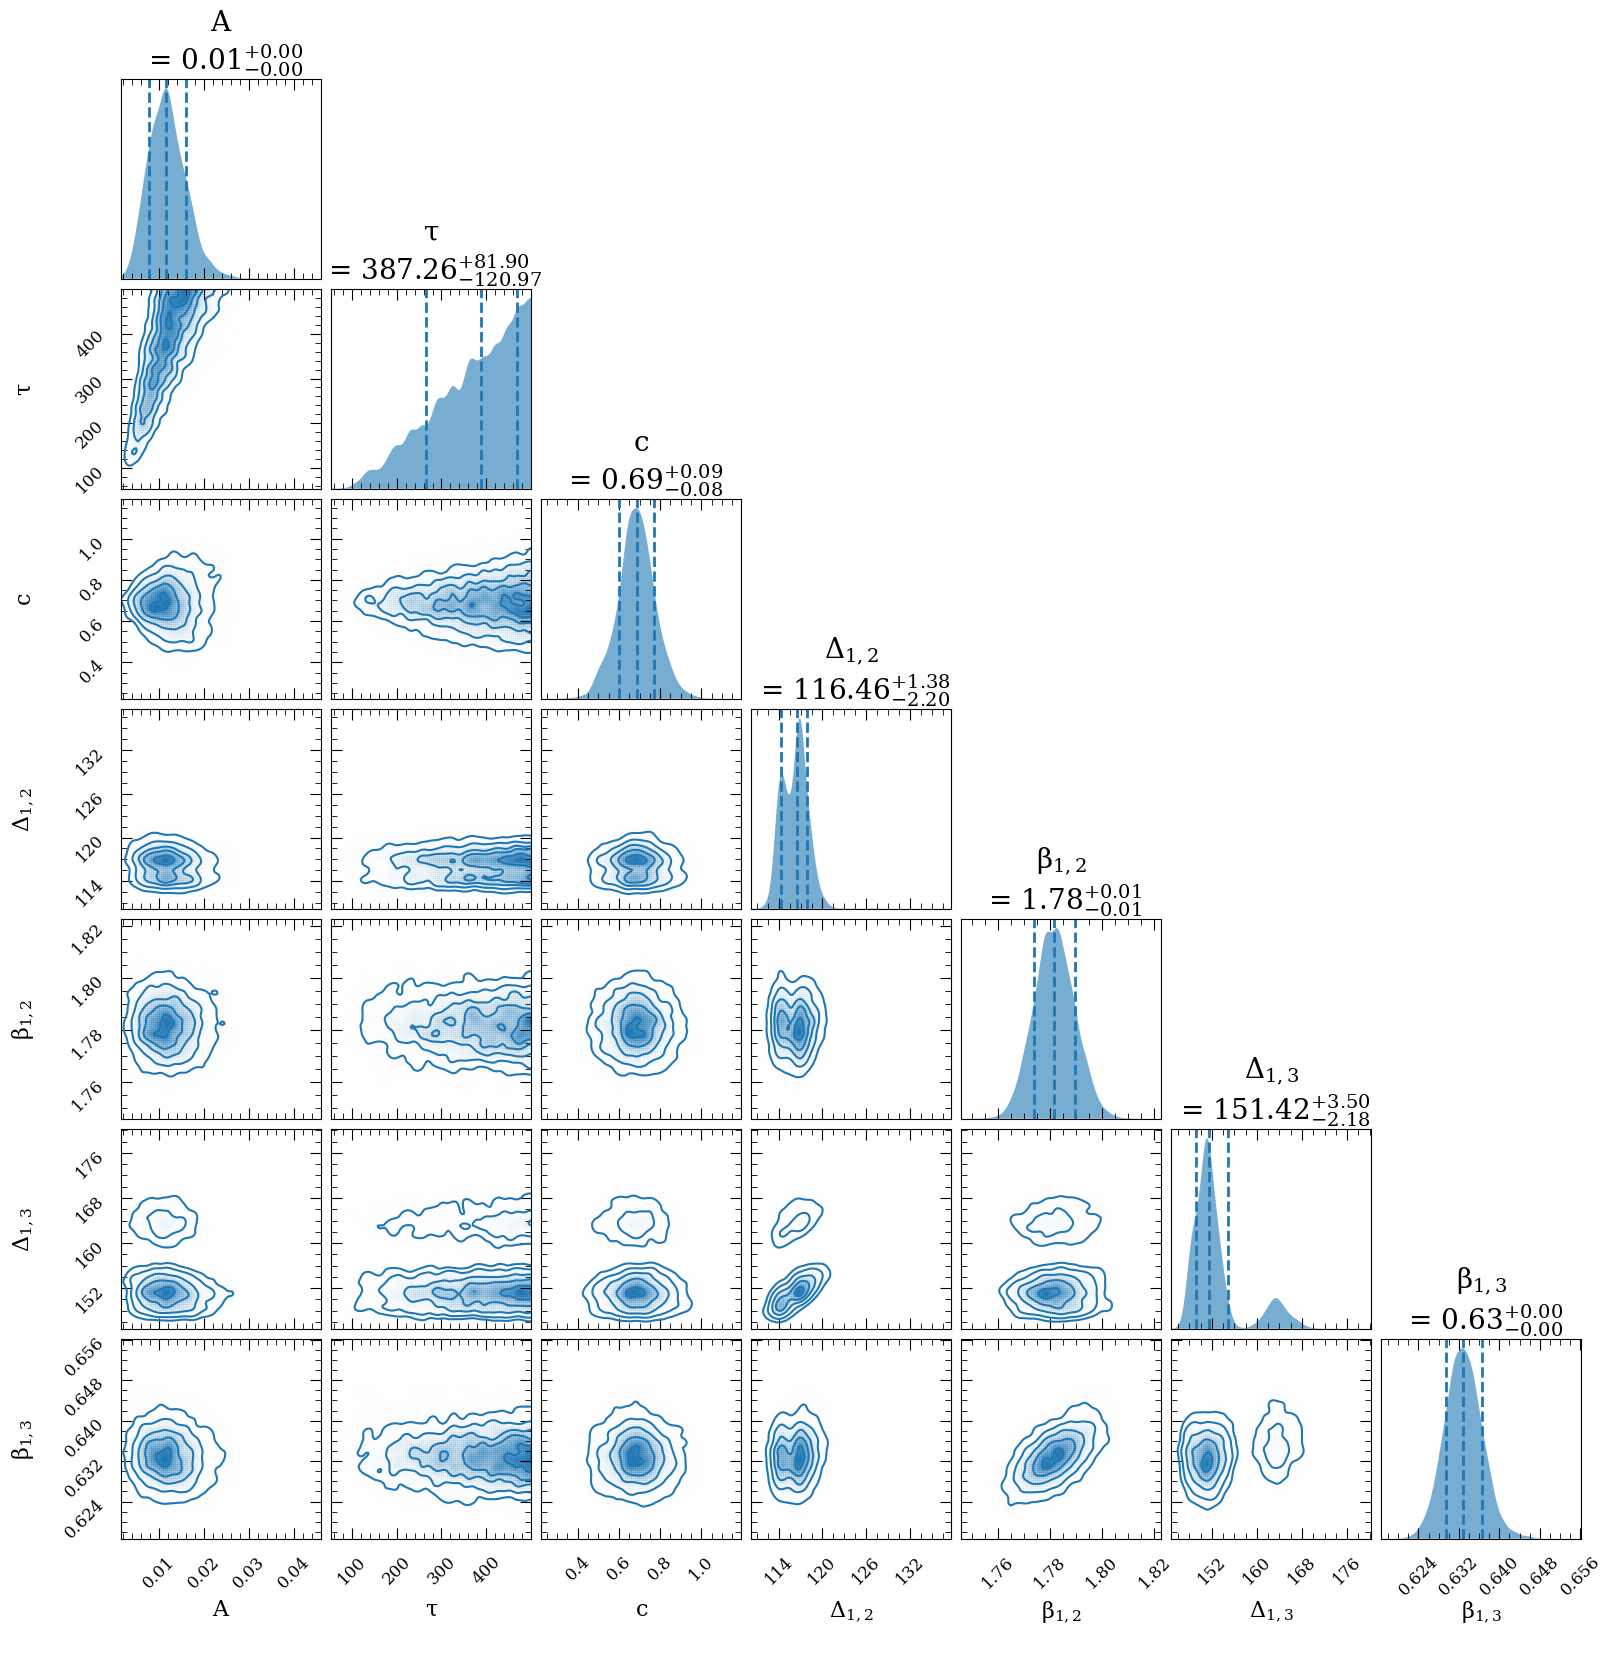

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

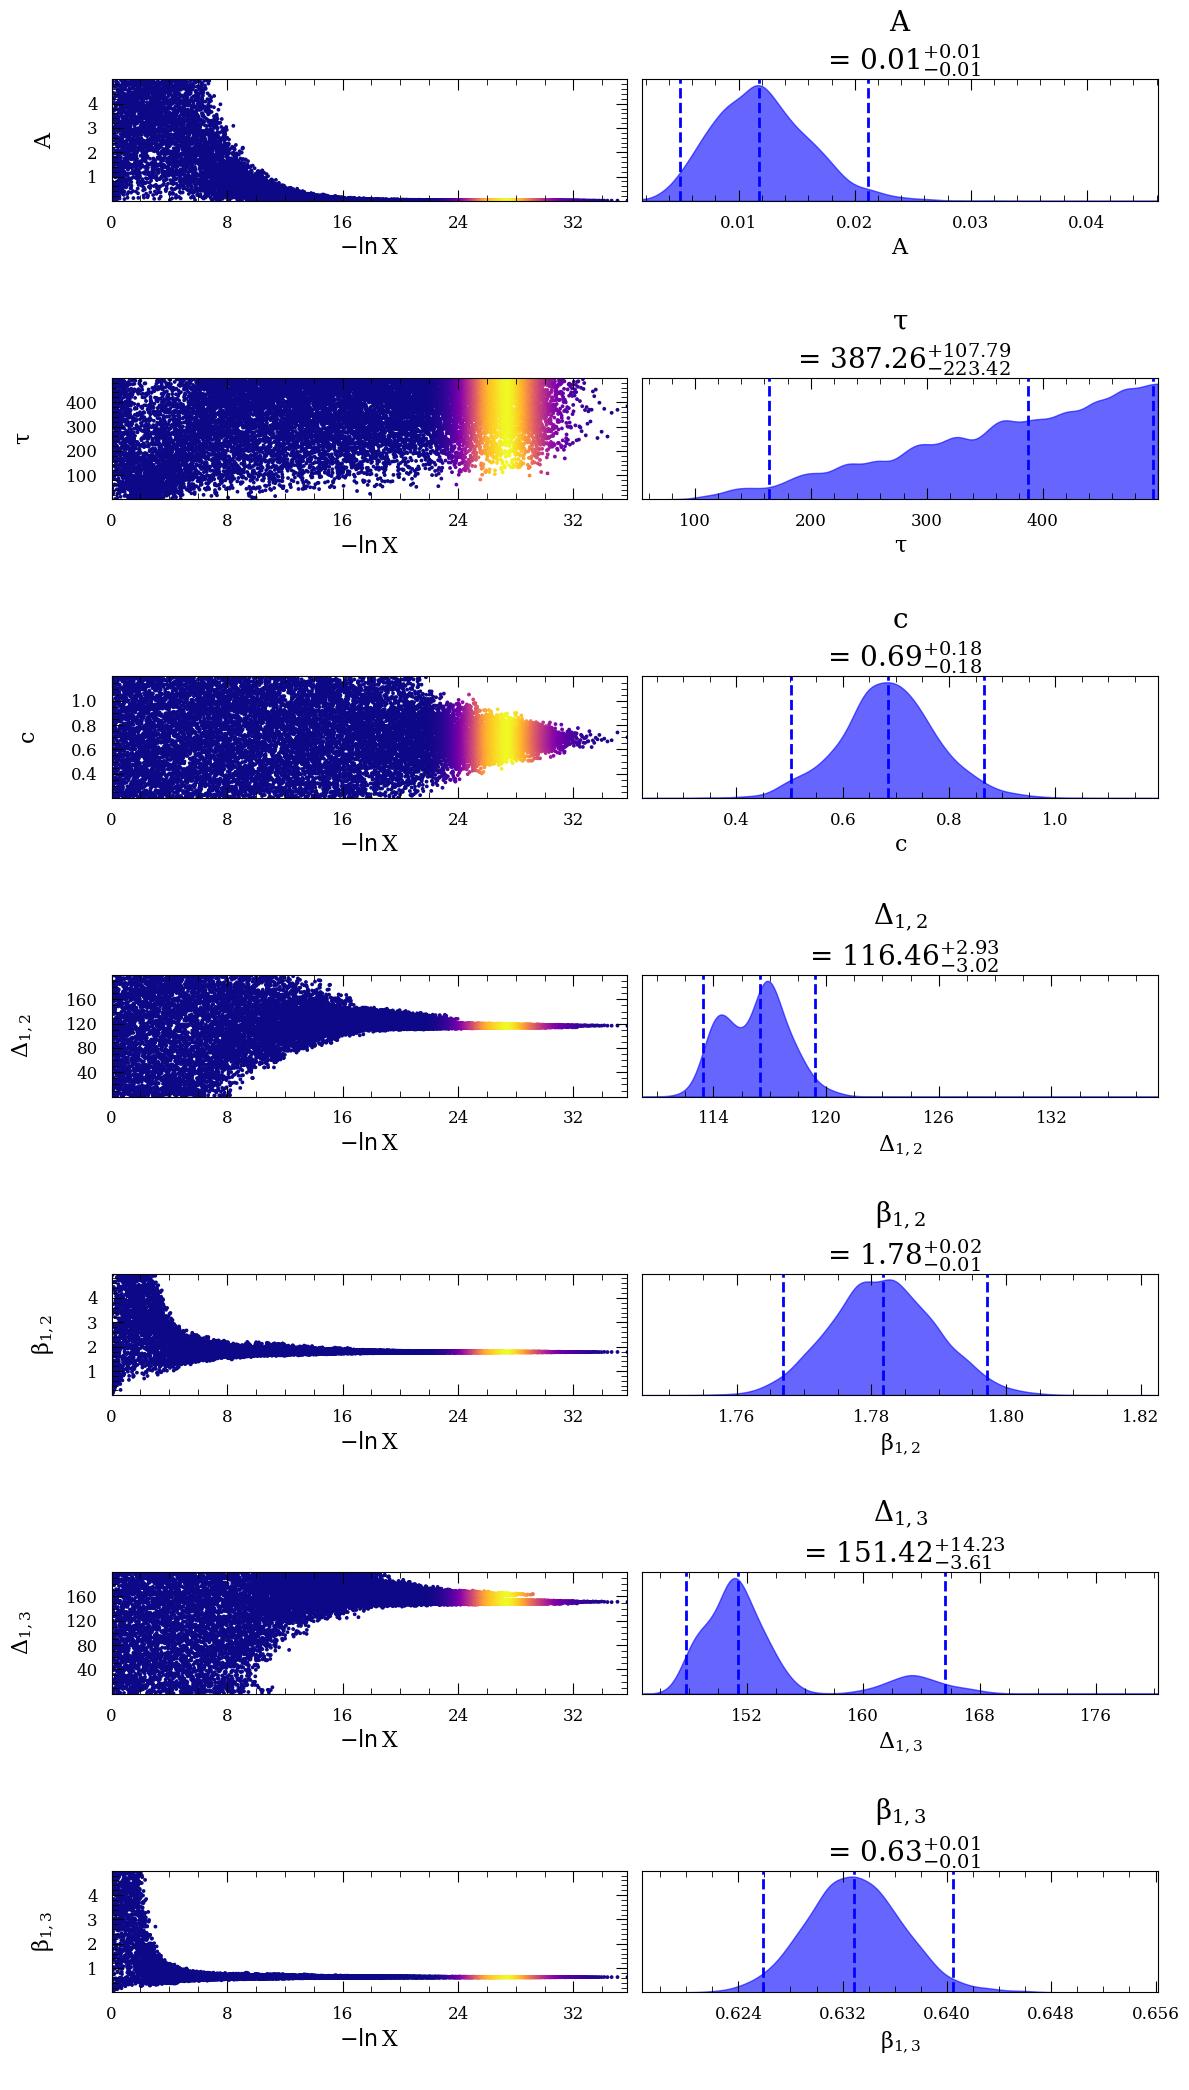

<Figure size 640x480 with 0 Axes>

In [5]:
param_names = ['$A$\n', '$\\tau$\n', '$c$\n', '$\\Delta_{1,2}$\n', '$\\beta_{1,2}$\n', '$\\Delta_{1,3}$\n', '$\\beta_{1,3}$\n']
fig = utils.make_corner(sampler.results, param_names=param_names)
plt.show()
plt.clf()

fig = utils.make_traceplot(sampler.results, param_names=param_names)
plt.show()
plt.clf()

## Plot the fitted light curve

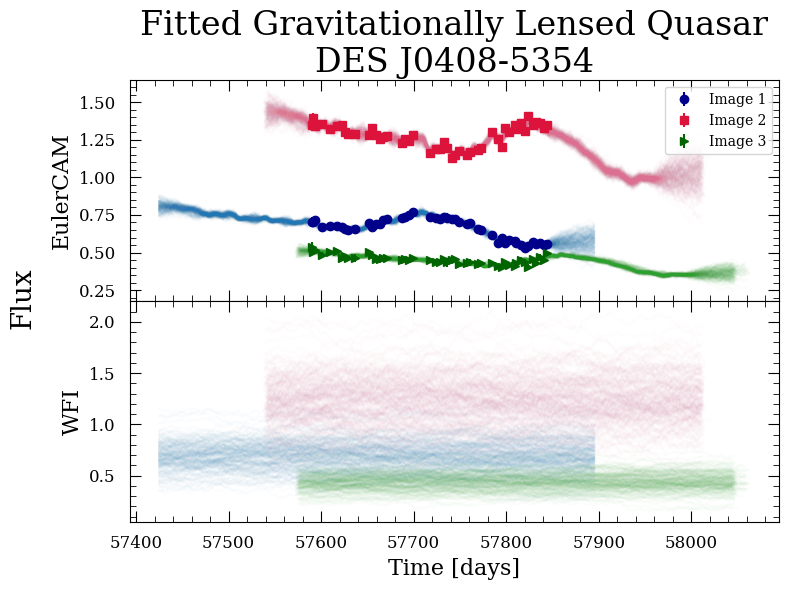

<Figure size 640x480 with 0 Axes>

In [6]:
# Ignore the "fits" to the WFI data. Those are just random realizations of the GP because
# it's not conditioning on any WFI data, as that data has been excluded from the table.
meanfunc = meanfuncs.UniformMean([0.7])
kernel = kernels.OUKernel([1, 50])
lensingmodel = lensingmodels.ConstantMagnification([0,1,0,1])
fig, ax = plot_fitted_quasar(data, sampler.results, kernel, meanfunc, lensingmodel, predict_times=np.arange(57425, 57896, 1),
                             title='Fitted Gravitationally Lensed Quasar\nDES J0408-5354')
plt.show()
plt.clf()